In [1]:
import warnings
# warnings.filterwarnings("ignore")


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import numpy as np
import gym
from tqdm import tqdm

import matplotlib.pyplot as plt
import collections
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
class Network(nn.Module):
    def __init__(self, input_dim, action_space, hidden_layers, activation_fn = nn.ReLU):
        super(Network, self).__init__()
        layers = [nn.Linear(input_dim, hidden_layers[0]), activation_fn()]
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(activation_fn())
        
        self.sequential = nn.Sequential(*layers)
        self.value_output = nn.Linear(hidden_layers[-1], 1)
        self.advantage_output = nn.Linear(hidden_layers[-1], action_space)
    
    def forward(self, x):
        state = x
        
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).to(device)
            state  = state.unsqueeze(0)
        
        hidden_output = self.sequential(state)
        value_fn = self.value_output(hidden_output)
        advantage_fn = self.advantage_output(hidden_output)
        
        value_fn = value_fn.expand(advantage_fn.size())
        action_fn = value_fn + advantage_fn - advantage_fn.mean(-1, keepdim=True).expand(advantage_fn.size())
        return(action_fn)


In [3]:
class DuelingDQN():
    def __init__(self, env):
        self.env_name = env
        self.env = gym.make(env)
        self.state = self.env.reset()[0]
        self.online_model = Network(len(self.state), self.env.action_space.n, (256, 128)).to(device)
        self.target_model = Network(len(self.state), self.env.action_space.n, (256, 128)).to(device)
        self.target_model.load_state_dict(self.online_model.state_dict())
        
        #Hyperparameters
        self.epsilon = 0.5
        self.min_epsilon = 0.01
        self.decay = (self.epsilon - self.min_epsilon) / 10000
        self.gamma = 0.95
        self.tau = 0.15
        self.lr = 1e-4
        self.buffer_size = int(1e6)
        self.min_buffer_size = 320
        self.mini_batch_size = 64
        
        #Other variables
        self.optimizer = optim.Adam(self.online_model.parameters(), self.lr)
        self.loss_fn = nn.MSELoss()
        self.replay_buffer = collections.deque(maxlen=self.buffer_size)
        
        self.eval_returns = []
    
    def optimise(self, experiences):
        states = [experience[0] for experience in experiences]
        actions = [experience[1] for experience in experiences]
        rewards = [experience[2] for experience in experiences]
        next_states = [experience[3] for experience in experiences] 
        is_terminals = [experience[4] for experience in experiences]
        
        action_values = self.online_model(np.array(states)).squeeze()
        idxs = torch.tensor(actions).to(device).long().unsqueeze(1)
        action_values = action_values.gather(1, idxs)
        
        with torch.no_grad():
            next_action_values = self.target_model(np.array(next_states)).detach().squeeze()
            next_action_values, _ = next_action_values.max(dim=1)
            
        target = np.array(rewards) + self.gamma*np.array(next_action_values.cpu())*(1-np.array(is_terminals))
        
        target = torch.from_numpy(target).to(device).unsqueeze(1).float()
        
        loss = self.loss_fn(action_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 
        
    def step(self, optimise  = True, update = True):
        if random.random() <= self.epsilon:
            action = self.env.action_space.sample()
        else:
            with torch.no_grad():
                action_values = self.online_model(self.state).detach()
                action = int(torch.argmax(action_values.squeeze()))
            
        next_state, reward, terminated, truncated , info = self.env.step(action)
        
        self.epsilon = max(self.epsilon - self.decay, self.min_epsilon)
        
        self.replay_buffer.append((self.state, action, reward, next_state, terminated and not truncated))
        
        self.state = next_state
        
        if terminated or truncated:
            self.state = self.env.reset()[0]
        
        if optimise and len(self.replay_buffer) >= self.min_buffer_size:
            self.optimise(random.sample(self.replay_buffer, self.mini_batch_size))
        
        if update:
            for target_param, online_param in zip(self.target_model.parameters(), self.online_model.parameters()):
                target_param.data.copy_(self.tau*online_param.data + (1.0-self.tau)*target_param.data)
    
    def eval_model(self, render):
        with torch.no_grad():
            eval_env = gym.make(self.env_name, render_mode = "human" if render else None)
            eval_episodes = 10
            for episode in range(eval_episodes):
                state = eval_env.reset()[0]
                done = False
                total_return = 0
                while not done:
                    action_values = self.online_model(state)
                    action = int(torch.argmax(action_values.squeeze()))
                    next_state, reward, terminated, truncated , info = eval_env.step(action)
                    if render:
                        eval_env.render()
                    done = terminated or truncated
                    
                    total_return += reward
                    state = next_state
                self.eval_returns.append(total_return)
            return np.mean(self.eval_returns[len(self.eval_returns) - eval_episodes: ])
    
    def plot_results(self):
        plt.plot(range(len(self.eval_returns)), self.eval_returns)
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.show()
                
    def train(self, time_stamps, eval_time_stamps, plot_time_stamps):
        for time_stamp in tqdm(range(1, time_stamps + 1)):
            self.step()
            
            if(time_stamp % eval_time_stamps) == 0:
                if self.eval_model(False) > 480.0:
                    print("Solved CartPole!")
                    break
            
            if(time_stamp % plot_time_stamps) == 0:
                self.plot_results()


 10%|▉         | 2990/30000 [00:19<03:26, 130.54it/s]

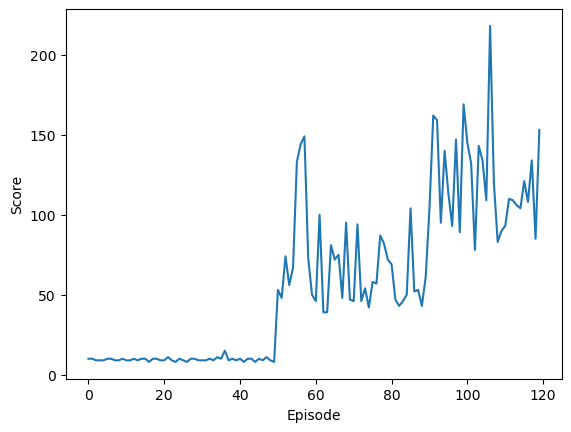

 11%|█         | 3218/30000 [00:22<03:20, 133.89it/s]

In [4]:
agent = DuelingDQN("CartPole-v1")
agent.train(30000, 250, 3000)

torch.save(agent.online_model, "model.pth")

In [ ]:
agent.eval_model(True)